# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover

We're going to go through the following with TensorFlow:

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [ ]:
! nvidia-smi

Sun Jul 24 07:28:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and becoming one with the data

In [ ]:
# Get data 
import zipfile
# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-07-24 07:28:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   270MB/s    in 0.6s    

2022-07-24 07:28:03 (270 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# how many images in each folder?
import os
# walk throught 10 percentage data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

Creating data loaders (preparing the data)

# We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen =  ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing Images: ")
test_data = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")



Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# let's fit our Resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220724-072817
Epoch 1/5
24/24 [==============================] - 33s 747ms/step - loss: 1.7778 - accuracy: 0.4200 - val_loss: 1.1224 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 16s 665ms/step - loss: 0.8543 - accuracy: 0.7453 - val_loss: 0.8361 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6066 - accuracy: 0.8160 - val_loss: 0.7575 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 15s 662ms/step - loss: 0.4667 - accuracy: 0.8693 - val_loss: 0.7034 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 16s 667ms/step - loss: 0.3749 - accuracy: 0.9080 - val_loss: 0.6786 - val_accuracy: 0.7784


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


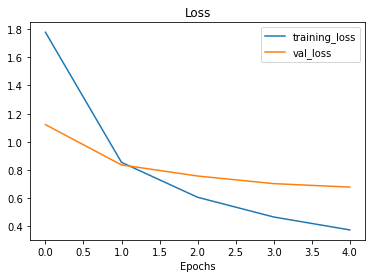

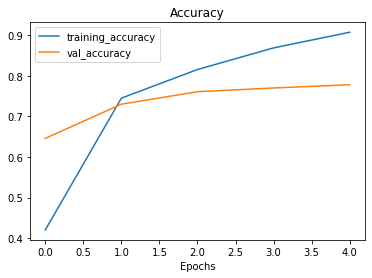

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create efficientNetB0 feature extractor model - details on efficientNet :https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
3 #fit model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])



Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220724-073014
Epoch 1/5
24/24 [==============================] - 25s 705ms/step - loss: 1.9094 - accuracy: 0.3973 - val_loss: 1.3522 - val_accuracy: 0.7304
Epoch 2/5
24/24 [==============================] - 15s 638ms/step - loss: 1.0941 - accuracy: 0.7747 - val_loss: 0.8889 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 15s 641ms/step - loss: 0.7709 - accuracy: 0.8347 - val_loss: 0.7146 - val_accuracy: 0.8348
Epoch 4/5
24/24 [==============================] - 15s 647ms/step - loss: 0.6188 - accuracy: 0.8640 - val_loss: 0.6202 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 15s 642ms/step - loss: 0.5189 - accuracy: 0.8933 - val_loss: 0.5648 - val_accuracy: 0.8564


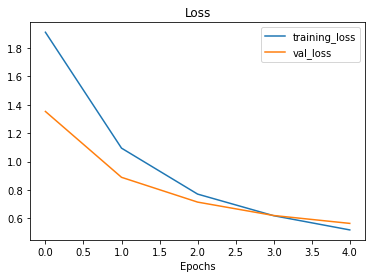

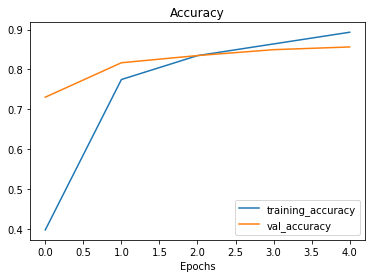

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=gNTl59HykjQ0xB5pGvMasfCQR3Wjwn&prompt=consent&access_type=off